# HMM SPEECH MODELING AND TRAINING

## Importing the Necessary Libraries

In [296]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
from scipy.io import wavfile

## Data Loading Process

In [297]:
base_path = r"C:\Users\giton\Desktop\MERIT\Probabilistic Methods\hmm_speech_recognition"

# Walk through all subdirectories and files
for dirpath, dirnames, filenames in os.walk(base_path):
    for filename in filenames:
        file_path = os.path.join(dirpath, filename)
        print(file_path)  # Or load/process the file as needed


C:\Users\giton\Desktop\MERIT\Probabilistic Methods\hmm_speech_recognition\hmm-speech-modelling-and-training.ipynb
C:\Users\giton\Desktop\MERIT\Probabilistic Methods\hmm_speech_recognition\.git\COMMIT_EDITMSG
C:\Users\giton\Desktop\MERIT\Probabilistic Methods\hmm_speech_recognition\.git\config
C:\Users\giton\Desktop\MERIT\Probabilistic Methods\hmm_speech_recognition\.git\description
C:\Users\giton\Desktop\MERIT\Probabilistic Methods\hmm_speech_recognition\.git\FETCH_HEAD
C:\Users\giton\Desktop\MERIT\Probabilistic Methods\hmm_speech_recognition\.git\HEAD
C:\Users\giton\Desktop\MERIT\Probabilistic Methods\hmm_speech_recognition\.git\index
C:\Users\giton\Desktop\MERIT\Probabilistic Methods\hmm_speech_recognition\.git\hooks\applypatch-msg.sample
C:\Users\giton\Desktop\MERIT\Probabilistic Methods\hmm_speech_recognition\.git\hooks\commit-msg.sample
C:\Users\giton\Desktop\MERIT\Probabilistic Methods\hmm_speech_recognition\.git\hooks\fsmonitor-watchman.sample
C:\Users\giton\Desktop\MERIT\Probab

 ## 🛠️ **Project Overview** 

This notebook demonstrates the development of a **speech recognition system** using a combination of **Hidden Markov Models (HMMs)** and **Logistic Regression** for word-level classification. The workflow includes:

1. **Data Augmentation**: Enhancing the dataset with pitch shifts, time stretching, and speed adjustments.
2. **Feature Extraction**: Extracting **MFCC** and **delta features** to capture spectral and temporal dynamics.
3. **Class-Specific HMMs**: Training separate HMMs for each word to model.
4. **Word-Level Classification**: Using log-likelihood scores from the HMMs as features to train a LR.
5. **Evaluation**: Assessing the system's performance reports and confusion matrices and addressing class imbalance using data augmentation and class weighting.

This notebook combines traditional HMM-based sequence modeling with modern machine learning techniques to achieve robust speech recognition.

## Get Input
#### Reads a .wav audio file using wavfile.read(). 

In [298]:
"""Extracting information about the audio file"""

file_path = "sample_audio_dataset/Beethoven_Diabelli_Variation_No._13.wav"
sample_path = os.path.join(base_path, file_path)
# Read the .wav audio file
sampling_freq, audio = wavfile.read(sample_path)
print( '\nShape:', audio.shape) # mono: (n_samples, ), stereo: (n_samples, 2)
print ('Datatype:', audio.dtype)
print ('Duration:', round(audio.shape[0] / float(sampling_freq), 3), 'seconds')


Shape: (659456, 2)
Datatype: int16
Duration: 14.954 seconds


##  Visualise audio

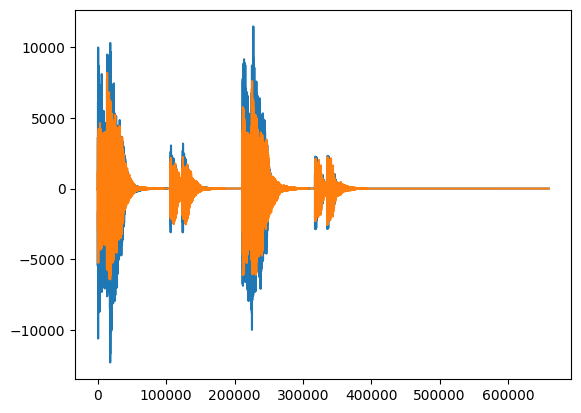

In [299]:
#Plot the complete audio 
plt.plot(audio)

##### Each point represents the amplitude of the signal at a given sample index.

##  Channel Division 
##### Stereo Channels: Since the signal is stereo, we separate and compare the left and right channels.

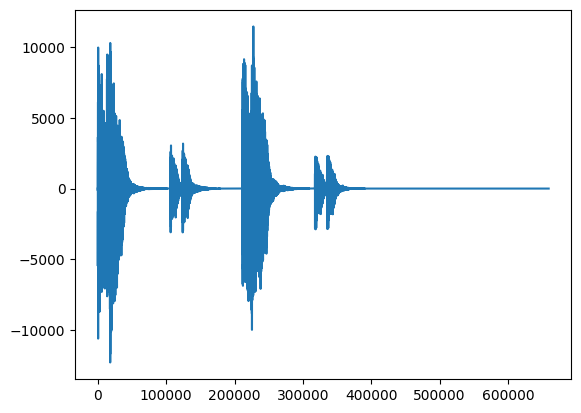

In [300]:
#Plot only left Channel
plt.plot(audio[:, 0], label='Left Channel')

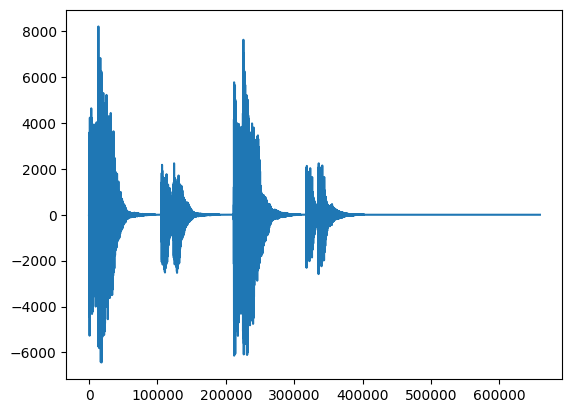

In [301]:
#Plot only right Channel
plt.plot(audio[:, 1], label='Right Channel')

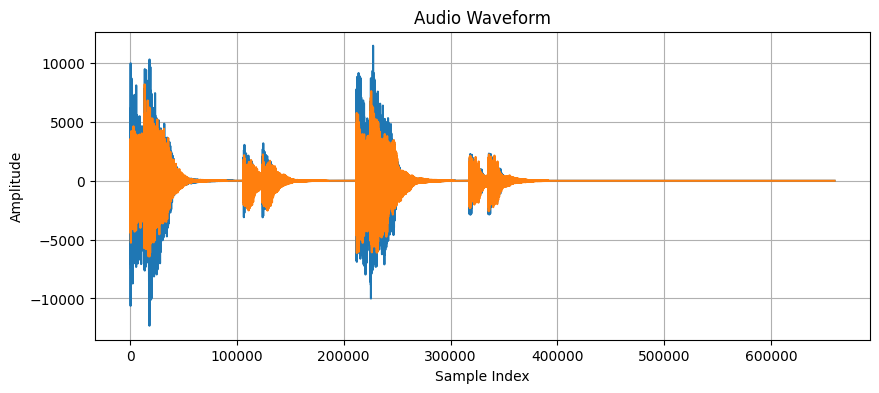

In [302]:
plt.figure(figsize=(10, 4))
plt.plot(audio)
plt.title("Audio Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

##### Consistent loudness normalization across samples. Reducing variations in amplitude could affect model performance or audio comparison.

## RMS/Volume Normalization: 

##### We calculated the RMS to analyze the perceived loudness and ensure uniform volume across audio signals.

These lines perform **audio normalization** and scaling:

1. **Normalization**: The audio signal is scaled to a range between `-1` and `1` by dividing by the maximum possible value or the maximum absolute value of the signal.
2. **Root Mean Square (RMS) Scaling**: The RMS of the signal is calculated to represent its energy, and the signal is scaled to a target RMS value (e.g., 0.1) to ensure consistent loudness across all audio samples.
3. **Truncation**: Optionally limits the audio to the first 30 samples, likely for testing or computational efficiency.

In [303]:
# audio=audio/2.**15
# audio=audio/np.max(np.abs(audio))
# audio=audio[:30]

# rms = np.sqrt(np.mean(audio**2))
# target_rms = 0.1


# scaling_factor = target_rms / rms
# audio = audio * scaling_factor

### **Positive Effects**:

1. **Consistency Across Samples**:
2. **Improved Generalization**:
3. **Numerical Stability**:
4. **Reduced Noise Sensitivity**:

### **Potential Risks**:
1. **Loss of Information**:
2. **Over-normalization**:

### **Overall Impact**:
- **Normalization** and **RMS scaling** generally improve the model's robustness and performance, especially for audio classification tasks.
- **Truncation**, however, should be used carefully to avoid losing important temporal information, as it could negatively affect the model's ability to learn key patterns.

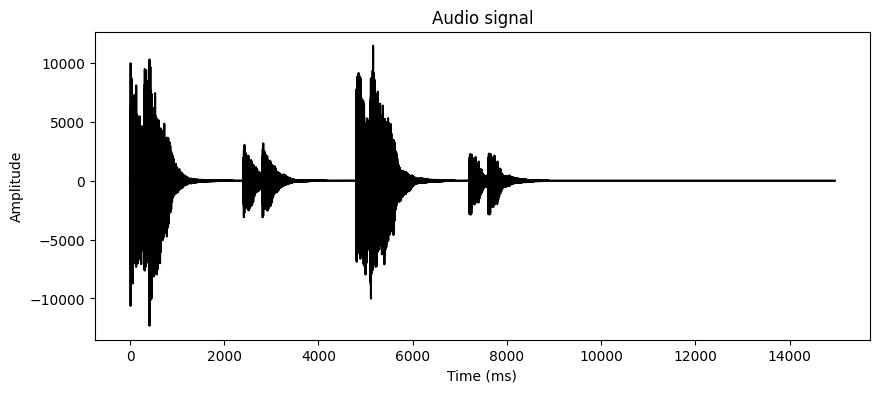

In [304]:
x_values = np.arange(0, len(audio), 1) / float(sampling_freq)
#Multiplying by 1000 converts seconds to milliseconds.
x_values *= 1000
plt.figure(figsize = (10, 4))
plt.plot(x_values, audio, color='black')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Audio signal')
plt.show()

**Duration:** Approximately 14 seconds 

**Amplitude:** The y-axis ranges -12,000 to 12,000, reflecting the dynamic range of the signal's amplitude, which indicates the intensity or loudness.

**Energy Distribution:** The signal's energy appears to occur in alternating large and smaller pulses. At the start (0–1000 ms), the is a large pulse and alternates to a smaller pulse at (2000-3000 ms). At the end (8000–14000 ms), the signal tapers off, indicating quieter sections or fades.

## Frequency Analysis: 

We aimed to analyze the frequency components of the signal (e.g., low, mid, or high frequencies).

In [305]:
transformed_signal = np.fft.fft(audio)

**Peak frequencies:** Peaks in the frequency spectrum indicate dominant frequencies.

**Noise:** Broad, non-peaked regions may indicate noise in the signal.

**Cutoff Frequencies:** Analyze if the signal is band-limited. 

In [306]:
#Calculate Half Length as Fourier Transform of a real-valued signal is symmetric
half_length = np.ceil((len(audio) + 1) / 2.0)
half_length=int(half_length)

#Extracts the magnitude of the first half of the FFT
transformed_signal = abs(transformed_signal[0:half_length])


#Square the Magnitude:
#Squares the magnitude to calculate the power spectrum (energy at each frequency).
#The power spectrum is proportional to the square of the amplitude of the frequency components.
transformed_signal **= 2

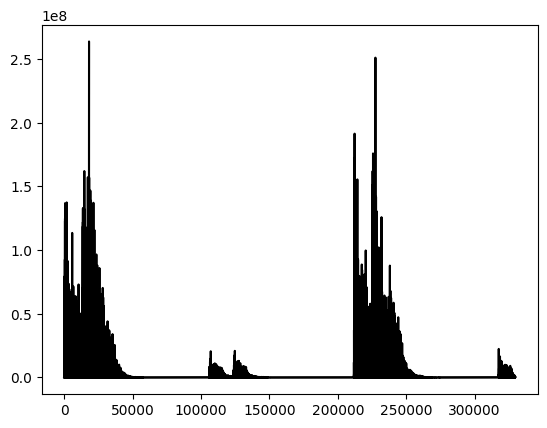

In [307]:
plt.plot(transformed_signal, color='black')

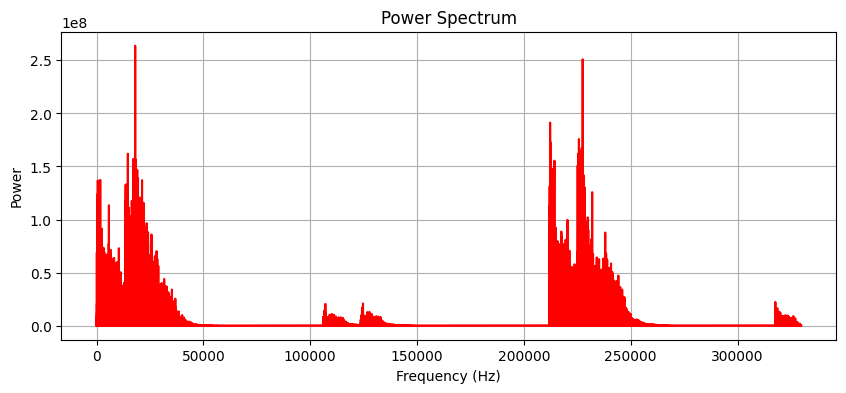

In [308]:
plt.figure(figsize=(10, 4))
plt.plot(transformed_signal, color='red')
plt.title("Power Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.grid()
plt.show()

* **Frequency Range:** The x-axis extends to about 325,000 Hz.

* **Dominant Frequencies:** Since we determined the audio sample has high and low pulses, we can observe the peaks in the spectrum (i.e., near 25.000 Hz and 225,000 Hz) indicating the primary frequency components of the audio signal and high-energy components at these frequencies. 

In [309]:
audio

array([[ 0,  0],
       [ 6,  0],
       [12,  2],
       ...,
       [ 0,  0],
       [ 0,  0],
       [ 0,  0]], shape=(659456, 2), dtype=int16)

In [310]:
freqs = np.fft.fftfreq(len(audio), d=1/sampling_freq)[:half_length]

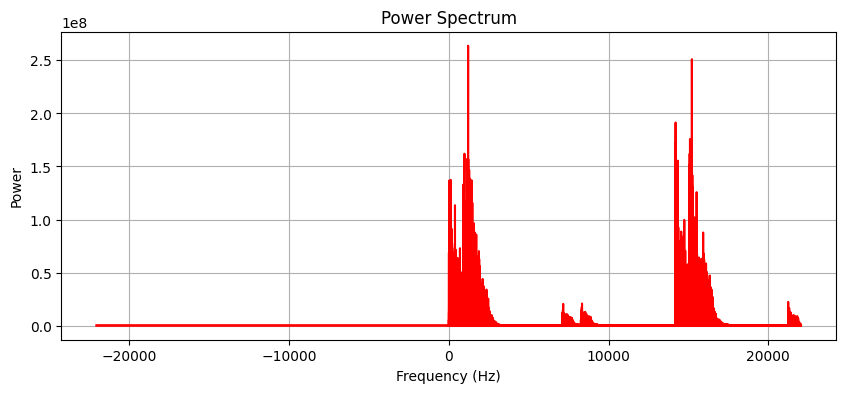

In [311]:
plt.figure(figsize=(10, 4))
plt.plot(freqs, transformed_signal, color='red')
plt.title("Power Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.grid()
plt.show()

## 🛠️ Power Representation:

#### Squaring the FFT values calculates the power spectrum, which represents the energy at each frequency. 

**Frequency Range:** The x-axis extends to 200,000 Hz.

**Energy Peaks:** Clear peaks are visible in the 100,000–175,000 Hz range, indicating high-energy components at these frequencies. These may arise from:

* High-frequency noise or interference.
* Ultrasonic signal components, if this is not a standard audio signal.

**Overall Energy Distribution:**

The power decreases significantly at lower frequencies compared to higher frequencies, which is unusual for most audio signals where lower frequencies often dominate. This might suggest:

* Non-audible high-frequency components.
* High-frequency noise.


# HMM model training

## Importing necessary libraries

In [312]:
from librosa.feature import mfcc
import librosa
from scipy.io import wavfile
from hmmlearn import hmm

**Librosa** library extract **MFCC (Mel Frequency Cepstral Coefficients)** features from an audio file. MFCCs are commonly used in audio and speech processing to represent the short-term power spectrum of sound on a mel scale. 

- **Number of windows**: Refers to the total number of time frames.
- **Length of each feature**: Indicates the number of MFCC coefficients computed for each time frame, representing the spectral characteristics of the sound.


The **Mel scale** is a perceptual scale of pitches that aligns with how humans perceive sound. It transforms frequencies from the linear Hertz (Hz) scale into a scale that reflects human auditory perception.

**Application**:
   - Widely used in speech and audio processing.
   - **Mel-Frequency Cepstral Coefficients (MFCCs)** are computed by applying the Mel scale to the power spectrum, emphasizing perceptually important frequency bands.


In [313]:
"""Extract MFCC features from the audio file"""
# Load the audio file using librosa
audio,sampling_rate = librosa.load(sample_path)
mfcc_features = mfcc(y=audio,sr=sampling_rate)
print("Number of windows =", mfcc_features.shape[0])
print('Length of each feature =', mfcc_features.shape[1])

Number of windows = 20
Length of each feature = 645


## Getting the Labels

We iterate through subfolders in the directory and extract file names as labels. 

* lists all subfolders or files in the directory.
* combines the base directory with the folder name to get the full path.
* extracts the folder name after the last * `\`, treating it as a label.

In [314]:
import os
audio_path = os.path.join(base_path, "audio")
for label in os.listdir(audio_path):
    if os.path.isdir(os.path.join(audio_path, label)):
        print(label)

apple
banana
kiwi
lime
orange
peach
pineapple


## Import HMM

A **Hidden Markov Model (HMM)** is a statistical model used to represent systems that are **stochastic** (having a random probability distribution) and **time-dependent**, where the underlying states are hidden (unobservable) but can be inferred through observable outputs.


In [315]:
class HMMTrainer(object):
   def __init__(self, model_name='GaussianHMM', n_components=7): # Gaussian HMM are suitable for modelling continuous data
     self.model_name = model_name
     self.n_components = n_components

     self.models = []
     if self.model_name == 'GaussianHMM':
        self.model=hmm.GaussianHMM(n_components=4)
     else:
        print("Please choose GaussianHMM")
   def train(self, X):
       self.models.append(self.model.fit(X))
       
   # Computes the log-likelihood score of the input data 
   def get_score(self, input_data):
       return self.model.score(input_data)

## Model Flow:
1. **Subfolder Processing**: Each subfolder corresponds to a label.
2. **Feature Extraction**: MFCC features are extracted for all `.wav` files in the subfolder.
3. **HMM Training**: Features are used to train an HMM for the label.
4. **Model Storage**: Trained HMM and its label are saved for future use.

In [316]:
hmm_models = []

for dirname in os.listdir(audio_path):
    
    # Get the name of the subfolder
    subfolder = os.path.join(audio_path, dirname)
    print(dirname)
    if not os.path.isdir(subfolder):
        continue
      
    # Extract the label
    label = dirname
    
    # Initialize variables
    X = np.array([])
    
    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')][:-1]:
        
        # Read the input file
        filepath = os.path.join(subfolder, filename)
        audio, sampling_freq = librosa.load(filepath)
        
        # Extract MFCC features
        mfcc_features = mfcc(y=audio, sr=sampling_freq)
        
        # Append to the variable X
        if len(X) == 0:
            X = mfcc_features[:, :15]
        else:
            X = np.append(X, mfcc_features[:, :15], axis=0)
        
        print('X.shape =', X.shape)
    
    # Train HMM
    hmm_trainer = HMMTrainer()
    hmm_trainer.train(X)
    
    # Append HMM and label to models
    hmm_models.append((hmm_trainer, label))
    
    # Reset the trainer
    hmm_trainer = None

apple
X.shape = (20, 15)
X.shape = (40, 15)
X.shape = (60, 15)
X.shape = (80, 15)
X.shape = (100, 15)
X.shape = (120, 15)
X.shape = (140, 15)
X.shape = (160, 15)
X.shape = (180, 15)
X.shape = (200, 15)
X.shape = (220, 15)
X.shape = (240, 15)
X.shape = (260, 15)
X.shape = (280, 15)
banana
X.shape = (20, 15)
X.shape = (40, 15)
X.shape = (60, 15)
X.shape = (80, 15)
X.shape = (100, 15)
X.shape = (120, 15)
X.shape = (140, 15)
X.shape = (160, 15)
X.shape = (180, 15)
X.shape = (200, 15)
X.shape = (220, 15)
X.shape = (240, 15)
X.shape = (260, 15)
X.shape = (280, 15)
kiwi
X.shape = (20, 15)
X.shape = (40, 15)
X.shape = (60, 15)
X.shape = (80, 15)
X.shape = (100, 15)
X.shape = (120, 15)
X.shape = (140, 15)
X.shape = (160, 15)
X.shape = (180, 15)
X.shape = (200, 15)
X.shape = (220, 15)
X.shape = (240, 15)
X.shape = (260, 15)
X.shape = (280, 15)
lime
X.shape = (20, 15)
X.shape = (40, 15)
X.shape = (60, 15)
X.shape = (80, 15)
X.shape = (100, 15)
X.shape = (120, 15)
X.shape = (140, 15)
X.shape = (16

## MFCC Feature Analysis 

The variable **`X`** contains the concatenated **MFCC features** extracted from all `.wav` files in a subfolder. Each row represents the MFCC coefficients (15 from the previous cell output) for a specified time frame, and the entire matrix represents the audio's spectral features for that subfolder. This is then used as input for training the HMM.

In [317]:
#MFCC features
X

array([[-546.34467  , -352.0923   , -295.52576  , ..., -336.79395  ,
        -324.38712  , -338.2609   ],
       [  99.92674  ,  192.42493  ,  219.49593  , ...,  227.40436  ,
         231.41406  ,  227.19489  ],
       [  10.186135 ,  -69.15028  ,  -89.49054  , ...,  -59.41118  ,
         -67.79985  ,  -65.32806  ],
       ...,
       [  -7.7276087,    3.5544562,   -4.591971 , ...,   -1.3805428,
           0.8600025,   -1.8735584],
       [  -6.9840274,    3.978588 ,   -2.0635414, ...,   -7.6143312,
          -2.8041928,   -4.3404274],
       [  -2.1185718,   -8.608407 ,  -16.01148  , ...,  -14.295001 ,
         -13.115952 ,  -17.259113 ]], shape=(280, 15), dtype=float32)

### Insights:
- **Shape**: How many time frames and coefficients are present.
- **Statistics**: Variation and range of MFCC values, which can indicate spectral diversity.
- **Visualization**: Temporal and spectral patterns in the audio data.
- **Correlation**: Relationships between MFCC coefficients to identify redundancies or dependencies.

In [318]:
print("Shape of X:", X.shape)

Shape of X: (280, 15)


## Output Stats 

In [319]:
# Calculate statistics
mean_values = np.mean(X, axis=0)
median_values = np.median(X, axis=0)
std_dev_values = np.std(X, axis=0)
range_values = np.ptp(X, axis=0)

# Combine into a DataFrame
stats_df = pd.DataFrame({
    "Mean": mean_values,
    "Median": median_values,
    "Standard Deviation": std_dev_values,
    "Range (Max-Min)": range_values
}, index=[f"MFCC_{i+1}" for i in range(X.shape[1])])

# Display dataframe
stats_df

,Mean,Median,Standard Deviation,Range (Max-Min)
MFCC_1,-19.950624,-5.302552,96.858154,774.201660
MFCC_2,-18.575989,-11.216863,88.474518,609.330994
MFCC_3,-18.429256,-15.643583,89.094162,600.277283
MFCC_4,-18.077477,-15.225343,88.230515,579.915894
MFCC_5,-18.365971,-13.076275,88.033356,579.475891
MFCC_6,-18.792059,-11.968794,88.316620,604.310242
MFCC_7,-19.305988,-12.234453,89.369850,615.242493
MFCC_8,-19.769333,-13.248327,91.322838,608.497192
MFCC_9,-20.496126,-13.974180,94.223495,628.764160
MFCC_10,-20.775160,-14.101014,95.717781,628.385071


In [320]:
print("Contains NaN values:", np.isnan(X).any())
print("Contains infinite values:", np.isinf(X).any())

Contains NaN values: False
Contains infinite values: False


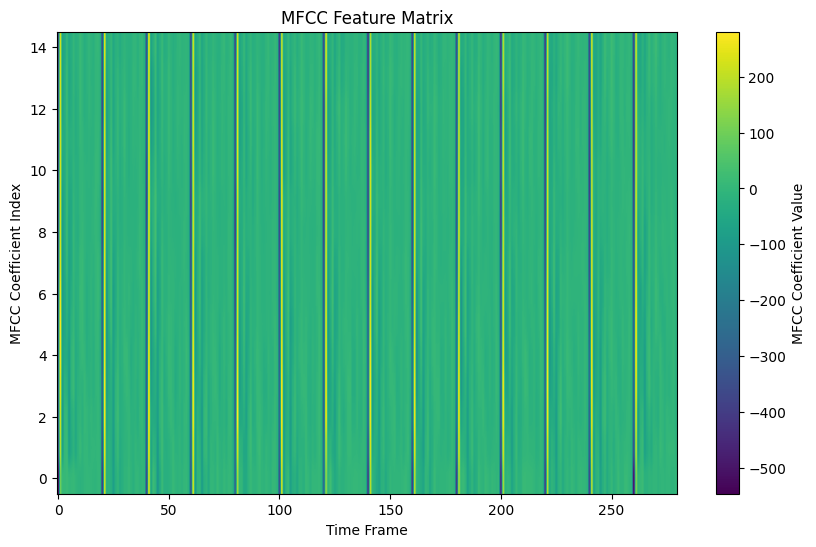

In [321]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(X.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='MFCC Coefficient Value')
plt.xlabel('Time Frame')
plt.ylabel('MFCC Coefficient Index')
plt.title('MFCC Feature Matrix')
plt.show()

## Output Analysis 

The visualization shows the spectral characteristics of an audio signal over time:

1. **X-Axis**: Represents the time frames of the audio, capturing short-term segments of the signal.
2. **Y-Axis**: Represents the MFCC coefficients (features) for each time frame, with lower indices capturing broad spectral energy and higher indices capturing finer details.
3. **Color Intensity**: Indicates the magnitude of the MFCC coefficients, with yellow representing higher values and purple lower values.

The alternating vertical patterns, shifting from green to purple and then yellow, suggest periodic changes in the spectral energy, reflecting a structured audio pattern such as the music from our sample.

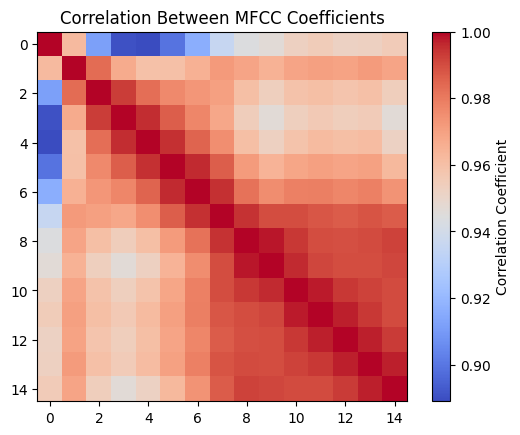

In [322]:
correlation_matrix = np.corrcoef(X.T)


# Plot the correlation matrix
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Between MFCC Coefficients')
plt.show()

## Heatmap Analysis 

Displays the relationships between different MFCC coefficients:

1. **Diagonal Line**: The strong red diagonal (value = 1.0) indicates perfect self-correlation.
2. **High Correlation**: Many off-diagonal coefficients show strong correlations (red regions), suggesting redundancy or strong relationships between certain MFCC features.
3. **Low/Negative Correlation**: Blue areas indicate weak or negative correlations, suggesting complementary features useful for distinguishing patterns in the audio.

It helps identify which features are highly interdependent and which provide unique information, useful for dimensionality reduction or feature selection.

In [323]:
hmm_models

[(<__main__.HMMTrainer at 0x10ad63bfdd0>, 'apple'),
 (<__main__.HMMTrainer at 0x10ad6419820>, 'banana'),
 (<__main__.HMMTrainer at 0x10b102b42f0>, 'kiwi'),
 (<__main__.HMMTrainer at 0x10adb1bf230>, 'lime'),
 (<__main__.HMMTrainer at 0x10b224811c0>, 'orange'),
 (<__main__.HMMTrainer at 0x10ad6418dd0>, 'peach'),
 (<__main__.HMMTrainer at 0x10ade7b28d0>, 'pineapple')]

In [324]:
len(hmm_models)

7

## Load new data for Testing

List of **file paths** to specific `.wav` audio files from different subfolders (representing labels) in a dataset. 

In [325]:
input_files = [
    os.path.join(base_path, "audio", "pineapple", "pineapple15.wav"),
    os.path.join(base_path, "audio", "orange", "orange15.wav"),
    os.path.join(base_path, "audio", "apple", "apple15.wav"),
    os.path.join(base_path, "audio", "kiwi", "kiwi15.wav")
]

## Model Testing

In [326]:
scores = []

# Extract MFCC features with 15 coefficients, consistent with training data
audio, sampling_freq = librosa.load(input_files[1])
mfcc_features = mfcc(y=audio, sr=sampling_freq)[:, :15]

# Iterate through trained HMM models
for item in hmm_models:
    hmm_model, label = item
    
    # Get the log-likelihood score for the input features
    score = hmm_model.get_score(mfcc_features)
    scores.append(score)

# Find the model with the highest score
index = np.array(scores).argmax()

# Extract the true label from the file path
true_label = os.path.basename(os.path.dirname(input_files[1]))

# Print the true label and predicted label
print("\nTrue:", true_label)
print("Predicted:", hmm_models[index][1])



True: orange
Predicted: orange


In [327]:
hmm_models

[(<__main__.HMMTrainer at 0x10ad63bfdd0>, 'apple'),
 (<__main__.HMMTrainer at 0x10ad6419820>, 'banana'),
 (<__main__.HMMTrainer at 0x10b102b42f0>, 'kiwi'),
 (<__main__.HMMTrainer at 0x10adb1bf230>, 'lime'),
 (<__main__.HMMTrainer at 0x10b224811c0>, 'orange'),
 (<__main__.HMMTrainer at 0x10ad6418dd0>, 'peach'),
 (<__main__.HMMTrainer at 0x10ade7b28d0>, 'pineapple')]

In [328]:
scores

[-1302.6355334619207,
 -1282.8033141533679,
 -1565.6493128761326,
 -1316.4624096940765,
 -1187.8517424401728,
 -1516.1008165429962,
 -1244.4132837366394]

## Score Analysis

* Each score represents the log-likelihood of the input MFCC features matching a particular model (label).
* The higher (less negative) the score, the better the fit between the features and the corresponding model

## HMM Model With Extra Features and Improved Parameters

In [329]:
import os
import librosa
import numpy as np
from librosa.feature import mfcc
from hmmlearn import hmm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [330]:
# Initialize variables
X_combined = np.array([])  # Combined MFCC features for all words
y_labels = []              # Labels for word-level classification
word_labels = []           # List of unique word labels

In [331]:
# Step 1: Prepare Training Data
for dirname in os.listdir(audio_path):
    subfolder = os.path.join(audio_path, dirname)
    if not os.path.isdir(subfolder):
        continue
    
    #label = subfolder[subfolder.rfind('/') + 1:]  # Extract label
    label = dirname
    word_labels.append(label)  # Store the label
    
    # Extract MFCC features for each audio file
    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')]:
        filepath = os.path.join(subfolder, filename)
        audio, sampling_freq = librosa.load(filepath)
        
        # Extract MFCC and delta features
        mfcc_features = mfcc(y=audio, sr=sampling_freq, n_mfcc=15)
        delta_features = librosa.feature.delta(mfcc_features)
        combined_features = np.vstack([mfcc_features, delta_features]).T  # Combine features
        
        # Append to the combined data
        if len(X_combined) == 0:
            X_combined = combined_features
        else:
            X_combined = np.append(X_combined, combined_features, axis=0)
        
        y_labels.append(label)  # Append label for each audio file

In [332]:
# Step 2: Train the Shared HMM
shared_hmm = hmm.GaussianHMM(n_components=15, covariance_type='diag', n_iter=200)
shared_hmm.fit(X_combined)

GaussianHMM(n_components=15, n_iter=200)

In [333]:
# Step 3: Compute Log-Likelihoods for Classifier Training
log_likelihoods = []
for dirname in os.listdir(audio_path):
    subfolder = os.path.join(audio_path, dirname)
    if not os.path.isdir(subfolder):
        continue
    
    for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')]:
        filepath = os.path.join(subfolder, filename)
        audio, sampling_freq = librosa.load(filepath)
        mfcc_features = mfcc(y=audio, sr=sampling_freq, n_mfcc=15)
        delta_features = librosa.feature.delta(mfcc_features)
        combined_features = np.vstack([mfcc_features, delta_features]).T
        
        # Compute log-likelihood score
        score = shared_hmm.score(combined_features)
        log_likelihoods.append(score)

In [334]:
# Prepare classifier training data
X_classifier = np.array(log_likelihoods).reshape(-1, 1)
y_classifier = np.array(y_labels)

In [335]:
# Step 4: Train the Word-Level Classifier

# Fix: Create y_classifier with one label per log-likelihood (i.e., per audio file)
# This assumes you have one label per file in the same order as log_likelihoods

# Build a new list of labels, one per file, matching log_likelihoods
y_classifier_list = []

for dirname in os.listdir(audio_path):
	subfolder = os.path.join(audio_path, dirname)
	if not os.path.isdir(subfolder):
		continue
	label = dirname
	for filename in [x for x in os.listdir(subfolder) if x.endswith('.wav')]:
		y_classifier_list.append(label)

# Now y_classifier_fixed should have the same length as log_likelihoods/X_classifier
classifier = LogisticRegression(C=0.1, max_iter=1000)
classifier.fit(X_classifier, y_classifier_list)

c:\Users\giton\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1, max_iter=1000)

In [336]:
# Step 5: Test the Model
input_file = os.path.join(audio_path, "orange", "orange15.wav")

# Extract MFCC and delta features from the test file
audio, sampling_freq = librosa.load(input_file)
# Extract MFCC features with 15 coefficients (features consistent with training)
mfcc_features = mfcc(y=audio, sr=sampling_freq, n_mfcc=15)
delta_features = librosa.feature.delta(mfcc_features)
combined_features = np.vstack([mfcc_features, delta_features]).T

# Get the log-likelihood score
test_score = shared_hmm.score(combined_features)

# Predict the label using the classifier
predicted_label = classifier.predict([[test_score]])

# Print results
print("Input file:", os.path.basename(input_file))
print("Predicted label:", predicted_label[0])

Input file: orange15.wav
Predicted label: orange



Classification Report:

              precision    recall  f1-score   support

       apple       0.60      0.60      0.60        15
      banana       0.38      0.40      0.39        15
        kiwi       0.40      0.40      0.40        15
        lime       0.58      0.47      0.52        15
      orange       0.93      0.93      0.93        15
       peach       0.87      0.87      0.87        15
   pineapple       0.71      0.80      0.75        15

    accuracy                           0.64       105
   macro avg       0.64      0.64      0.64       105
weighted avg       0.64      0.64      0.64       105



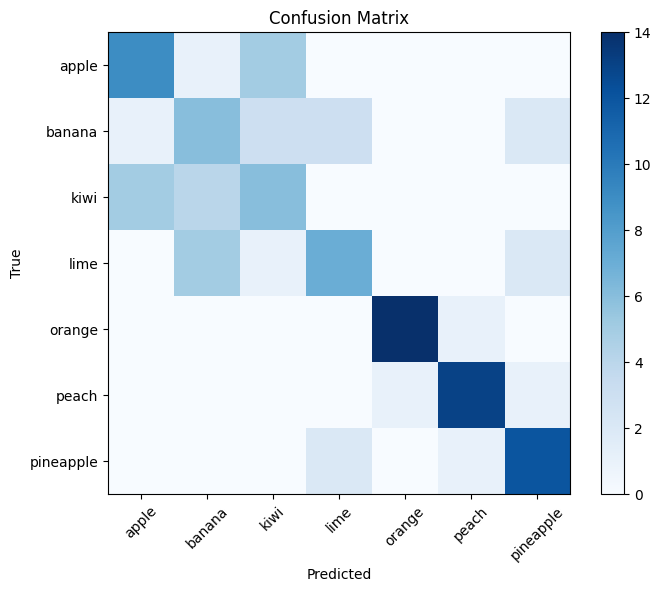

In [337]:
# Step 6: Evaluate the Classifier
y_pred = classifier.predict(X_classifier)
print("\nClassification Report:\n")
print(classification_report(y_classifier_list, y_pred))

# Optional: Plot the Confusion Matrix
unique_labels = sorted(list(set(y_classifier)))
cm = confusion_matrix(y_classifier_list, y_pred, labels=unique_labels)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title("Confusion Matrix")
plt.xticks(np.arange(len(unique_labels)), unique_labels, rotation=45)
plt.yticks(np.arange(len(unique_labels)), unique_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### Performace Improved Yet for some classes showing low performnace 


* Feature Enhancement: Added delta-MFCC features for capturing temporal dynamics.
* HMM Parameter Tuning: n_components and n_iter.
* Regularized Classifier:Used LR with L2 regularization (C=0.1).
* Robust Testing: MFCC and delta features for the test file.
